In [1]:
import os
DATASETS_PATH = os.path.join(os.path.expanduser('~/Projects/UpgradDemos/Datasets'))
IMAGES_PATH = os.path.join(os.path.expanduser('~/Projects/UpgradDemos/Images'))
CHECKPOINTS_PATH = os.path.join(os.path.expanduser('~/Projects/UpgradDemos/Checkpoints'))

# from google.colab import drive
# drive.mount('/content/gdrive')
# IMAGES_PATH = os.path.join('/content/gdrive/My Drive/',
#                            'Documents/IIITB/Courses/Upgrad/xAI/images')

In [2]:
from dataclasses import dataclass

@dataclass
class LimeHyperparameters:
    # Number of local samples generated for every datapoint to be explained
    n_local_samples = 100
    # 'Explanation Complexity' - #'significant' features to retain, tree depth etc.
    k = 5
    # Sampling parameter --- used for generating the local samples
    # interpretation will depend on the sampling strategy used
    alpha = 0.1
    # Kernel width for an RBF kernel --- used to compute pairwise distances using an RBF kernel
    rbf_weight_kernel_width = 0.75

**LIME - Locally-Interpretable Model-agnostic Explanations**<br>
Explanation-Space: A compact / sparse representation for the input datapoints<br>
**xp-space**: Explanation Space; **inp-Space**: Input Space<br>
**xp_** --- is often used as a prefix to denote "explainable"<br>
<br>
**Convention**<br>
--- methods ending with single underscore (\_) are meant to be overridden in subclasses<br>
--- methods starting with a single underscore (\_) are meant to be 'private' methods, not to be called from ourside the class.

# Default data class for vanilla tabular, numeric data

In [3]:
import numpy as np
from numpy import ndarray as Array
from typing import Any, Tuple, List
from math import prod

class LimeData:
    """Encapsulates the data, the predictions for which require explanations"""
    def __init__(self,
                 x:Array,
                 hp:LimeHyperparameters):
        super().__init__()
        self.hp = hp
        # 'x' is in the inp-space
        self.x:Array = x
        # xp-representations of 'x' along with local samples around each 'x' in the xp-space
        self.xp_augmented:Array = None
        # Points in the input space corresponding to each of the xp-space augmented samples
        self.perturbed_x:Array = None
        # Weight for each sample in 'self.xp_augmented'
        self.weights:Array = None
        print(f'{self.x.shape[0]} Points for explanation with {self.inp_attr_shape} features each')

    @property
    def xp_local(self) -> Array:
        """Return the xp-representations of 'x' and local samples in the
        xp-space around each data point in 'x' and generate a weight for each
        sample"""
        if self.xp_augmented is None:
            # Generate the xp-representations of 'x'
            xp_x = self.gen_xp_representations_()
            assert xp_x.shape[0] == len(self), f'{xp_x.shape[0]} != {len(self)}'

            # Generate locally perturbed samples in the vicinity of each of the inputs in 'x'
            # in the xp-space
            local_samples = self.gen_local_samples_(xp_x)
            assert local_samples.shape[0] == len(self), \
                    f'{local_samples.shape[0]} != {len(self)}'

            # Merge the xp-version of the input x into the samples
            # The first 'sample' is the original datapoint
            self.xp_augmented = np.concatenate((np.expand_dims(xp_x, axis=1),
                                               local_samples),
                                               axis=1)
            assert self.xp_augmented.shape[0] == len(self), \
                    f'{self.xp_augmented.shape[0]} != {len(self)}'

            # Find the corresponding points in the input space
            self.perturbed_x = self.reverse_map_()
            assert self.perturbed_x.shape == (len(self), *self.inp_samples_shape),\
                    f'{self.perturbed_x.shape} != {(len(self), *self.inp_samples_shape)}'

            # Assign weights to each local sample w.r.t the base datapoint
            self.weights = self.get_sample_weights_()
            assert self.weights.shape == (len(self), self.n_samples,),\
                    f'{self.weights.shape} != {(len(self), self.n_samples)}'

        return self.xp_augmented

    # ======= Methods that can / need to be reimplemented in derived classes =========

    def xp_labels_(self,
                   i:int,
                   idxs)-> Tuple[str]:
        """Labels associated with a given set (as an array of feature indexes) of xp-features for a given datapoint 
        with index 'i' --- this is accommodate cases where the labels are different for different datapoints"""
        # Default Implementation: Index itself is the label"""
        return tuple([('Feature ' + str(int(i))) for i in idxs])

    def gen_xp_representations_(self) -> Array:
        """Generate the xp-representations of each datapoint in 'x'
        The xp-features have to be one dimensional. It is assumed that the array
        returned by this will have the datapoint id and the xp-features as the 0, 1 dimensions.
        """
        # Default implementation where xp-space is the same as the input space
        return self.x

    def xp_flatten_transform_(self,
                              z:Array) -> Array:
        """This is called while building the local linear model for the input datapoints --- 
        'z' here represents the xp-representations. This function transforms the 'z' into a flat one-dimensional 
        numeric vector as the final xp-representation for each datapoint.
        Often this function does nothing -- just returns 'z' as is, since in most cases
        the xp-representations returned by gen_xp_representations_ are already flat."""
        return z

    def gen_local_samples_(self,
                           z:Array) -> Array:
        """Generate 'self.n_local_samples' samples in the vicinity of every datapoint in
        'z' in the xp-space"""
        # Default Implementation: Generate Gaussian samples around each point in 'z'
        # 'alpha' is treated as the variance of the Gaussian from which we sample"""
        augmented_x = np.expand_dims(z, axis=1)
        noise = np.random.normal(0, self.hp.alpha,
                                 size=(self.n, self.hp.n_local_samples, *self.inp_attr_shape))
        return augmented_x + noise

    def remove_padding_(self,
                        i:int,
                        samples:Array) -> Array:
        """Remove padding if any that was added for the i-th datapoint
        By default we don't do anything"""
        return samples
        
    def reverse_map_(self) -> Array:
        """Find the points in the inp-space for every point in 'z' in the xp-space"""
        # Default implementation where xp-space is the same as the input space
        return self.xp_local

    def diff_(self, x:Array, y:Array) -> Array:
        """Find the difference between two arrays
        This could be reimplemented to other 'differences' like the Hamming distance
        Used in the default get_sample_weights_ method"""
        return (x - y)

    def get_sample_weights_(self) -> Array:
        """Assign weights to each sample in 'self.xp_augmented'
        The weights are relative to the original data point (sample 0, in dim 1)"""
        # Default implementation where Weights use a RBF kernel"""
        n_values = prod(self.inp_attr_shape)
        original_x = np.expand_dims(self.perturbed_x[:,0], axis=1).\
                        reshape(self.n, 1, n_values)
        perturbed_x = self.perturbed_x.reshape(self.n, self.n_samples, n_values)
        distances = np.linalg.norm(self.diff_(perturbed_x, original_x), axis=2)
        return np.exp(-(distances**2) / (2 * self.hp.rbf_weight_kernel_width**2))

    # ===================================================================================

    def __len__(self):
        """Number of data points to be 'explained'"""
        return self.x.shape[0]
    @property
    def n(self) -> int: return len(self)
    @property
    def n_samples(self) -> int: return self.xp_local.shape[1]

    @property
    def inp_attr_shape(self) -> Tuple:
        """Shape of the input attributes"""
        return self.x.shape[1:]

    @property
    def xp_attr_shape(self):
        """Shape of the xp-attributes"""
        return self.xp_local.shape[2:]

    @property
    def local_samples_shape(self) -> Tuple:
        return (self.n_local_samples, *self.xp_attr_shape)
    @property
    def inp_samples_shape(self) -> Tuple:
        return (self.n_samples, *self.inp_attr_shape)
    @property
    def xp_samples_shape(self) -> Tuple:
        return (self.n_samples, *self.xp_attr_shape)


In [4]:
from abc import ABC, abstractmethod

class LimeModel(ABC):
    """Encapsulates the model whose predections need explanations"""
    def __init__(self,
                 model:Any,
                 in_shape:Tuple,
                 out_shape:Tuple):
        super().__init__()
        self.model = model
        self.in_shape = in_shape
        self.out_shape = out_shape

    # ======== Methods that need to be reimplemented in derived classes =======
    @abstractmethod
    def predict_(self,
                 x:Array) -> Array:
        """Apply the model on any given set of inputs"""
        pass

    @abstractmethod
    def decisions_(self,
                   predictions:Array) -> Tuple[Tuple, Tuple]:
        """Decisions implied by the model predictions
         --- both as 'values' and a printable labels for the values"""
        pass

    @abstractmethod
    def prediction_scores_(self,
                           predictions:Array,
                           decisions:Tuple) -> Array:
        """Find the prediction scores for a given decision (class, etc.) --- the scores
        could be a score, probability, etc."""
        pass
    # ===================================================================================

# Core LIME Algorithm<br>
Lime finds a local model that minimizes the objective<br>
$$\arg\min_g \mathcal{L}(f,g,\pi_x) + \Omega(g)$$
where $\mathcal{L}$ is the loss function between $f$ representing the model we are trying to explain, $g$ the 'explanation function' which is a local approximation around the given input point $x$ and $\pi_x$ is the function assigning weights to each sample in the vicinity of $x$. $\Omega(g)$ is the regularizer representing the complexity of the local function $g$ --- clearly it is meant to discourage very complex 'explanations'.

The default implementation here using linear local models, in particular k-LASSO and Ridge regression is the version that was originally published as '“Why Should I Trust You?”
Explaining the Predictions of Any Classifier' by Marco Tulio Ribeiro, Sameer Singh, and Carlos Guestrin in 2016.

In [ ]:
from sklearn.linear_model import lars_path
import matplotlib.pyplot as plt

class Lime:
    """The main LIME algorithm"""
    def __init__(self, hp:LimeHyperparameters, explanation_model:Any):
        super().__init__()
        self.hp = hp
        # Local explanation model --- the default implementation uses Ridge regression
        self.explanation_model = explanation_model

    # ======== Methods that can / need to be reimplemented in derived classes =======

    def shortlist_k_features_(self,
                              local_samples:Array,
                              targets:Array) -> Array:
        """Extract the k significant xp-attributes"""
        # Ensure the local_samples have a 'flat' representation
        assert local_samples.ndim == 2, f'{local_samples.ndim} != 2'

        # This is the default implementation as in the original LIME paper
        # this extracts the significant xp-attributes from the lars_path
        alphas, active_indices, coeffs = lars_path(local_samples.astype(np.float64), targets.astype(np.float64),
                                                   method='lasso', verbose=False)
        n_nonzero_coeffs = [np.sum(coeffs[:, i] != 0) for i in range(coeffs.shape[1])]
        diff_k = np.abs(np.array(n_nonzero_coeffs) - self.hp.k)
        top_k_iter = np.argmin(diff_k)
        return np.nonzero(coeffs[:, top_k_iter])[0]

    def get_sparse_local_model_(self,
                                local_samples:Array,
                                targets:Array,
                                weights:Array,
                                feature_labels:Tuple) -> Tuple[Any, Tuple]:
        """
        This finds the model 'g' that minimizes the objective using the ~K significant xp-attributes
        local_samples: are the xp-representations
        targets: are the 'f' function values
        weights: are the \\pi_x values.
        Returns a pair --- the objective minimizing model (Any) and the indices of the significant xp-features (Tuple)
        """
        # Default implementation using the linear local model used in the original paper on LIME
        # The local approximation is a linear regression model obtained through Ridge regression
        assert local_samples.shape[0] == targets.shape[0] == weights.shape[0],\
                f'{local_samples.shape[0]} != {targets.shape[0]} != {weights.shape[0]}'
        assert len(targets.shape) == len(weights.shape) == 1,\
                f'{targets.shape} != {weights.shape}'
        # Ensure the local_samples have a 'flat' representation
        assert local_samples.ndim == 2, f'{local_samples.ndim} != 2'

        # Get the significant features
        top_indices = self.shortlist_k_features_(local_samples, targets)
        print(f'Shortlisted features: {[feature_labels[i] for i in top_indices]}')

        # Generate the local linear model over the shortlisted features
        self.explanation_model.fit(local_samples[:,top_indices],
                                   targets,
                                   sample_weight=weights)
        print(f'Found local linear model with Coeffs: {self.explanation_model.coef_}')
        return top_indices

    def feature_scores_(self) -> Array:
        """Return the scores for the xp-features in the local_model"""
        # Assumes the explanation model is a linear model
        return self.explanation_model.coef_

    def plot_explanation_(self,
                          i:int,
                          decision_label:str,
                          label_value_strengths:List[Tuple],
                          data:LimeData):
        """Plot the explanation for the decision 'decision_label for the ith test datapoint
        label_value_strengths: is the list of tuples of (feature_label, feature_value and feature_strength), 'feature_strength' being the contribution of that feature to the
        decision.
        """
        print(f'Explanation:')
        label_value_strengths = sorted(label_value_strengths,
                                       key=lambda x:x[2], reverse=True)
        for label, value, strength in label_value_strengths:
            print(f'{label}: Value {value:.3F}, Strength {strength}')
        fig, ax = plt.subplots()

        labels, values, strengths = zip(*label_value_strengths)
        bar_colors = [('red' if s < 0 else 'green') for s in strengths]
        label_values = [f'{l} ({v:.3F})' for l, v in list(zip(labels, values))]
        y_pos = np.arange(len(label_values))
        ax.barh(y_pos, strengths, align='center',color=bar_colors)
        ax.set_yticks(y_pos, labels=label_values)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Feature Stength')
        ax.set_ylabel('Feature - Value')
        ax.set_title(f'Explanation for model prediction {decision_label} on datapoint {i}')
        plt.show()

    # ===================================================================================

    def get_sample_predictions(self,
                               model:LimeModel,
                               augmented_data:LimeData):
        """Get the model prediction for each datapoint (the original and the local samples)
        in 'augmented_data'"""
        # Flatten the first two dims of perturbed_x to bring it to the input format
        perturbed_x = np.reshape(augmented_data.perturbed_x,
                                 ((len(augmented_data) * augmented_data.n_samples),
                                  *augmented_data.inp_attr_shape))

        # Get the model predictions for the perturbed samples and reshape it back
        sample_predictions = model.predict_(perturbed_x)

        sample_predictions = np.reshape(sample_predictions,
                                        (len(augmented_data),
                                         augmented_data.n_samples,
                                         *model.out_shape))

        return sample_predictions

    def explain(self,
                model:LimeModel,
                data:LimeData):
        """Explain the action/decision of the 'model' on the datapoints in 'data'"""
        # Get/generate local samples in the interpretable space
        xp_samples = data.xp_local
        print()
        print(f'Augmented Data genereated with {data.xp_local.shape[1]-1} local samples around each input point')
        print(f'Augmented Data shape: {data.xp_local.shape}')

        # Get the model predictions for the samples
        sample_predictions = self.get_sample_predictions(model, data)

        # Get the decisions for each original data point and the printable decision labels
        decisions, decision_labels = model.decisions_(sample_predictions[:,0])
        assert len(decisions) == len(data) == len(decision_labels), \
                f'{len(decisions)} != {len(data)} != {len(decision_labels)}'

        print('Generating Model Predictions for all the local samples ...')
        # Get the prediction scores for the data points for the given decisions
        prediction_scores = model.prediction_scores_(sample_predictions, decisions)
        assert prediction_scores.shape == (len(data), data.n_samples),\
                f'{prediction_scores.shape} != {(len(data), data.n_samples)}'

        # Generate an explanation of the action of the model on each data point in 'x'
        for i in range(len(data)):
            # Explain the decision for the ith data point
            decision_label = decision_labels[i]
            print()
            print(f'Explaining Model Prediction {decision_label} for datapoint {i+1}')
            samples = xp_samples[i]
            assert samples.shape == data.xp_samples_shape, \
                        f'{samples.shape} != {data.xp_samples_shape}'

            # Remove padding if any that was added for this datapoint
            samples = data.remove_padding_(i, samples)
            print(f'Samples shape after removing padding: {samples.shape}')

            # Flattening the representation for each sample to make it linear
            samples = data.xp_flatten_transform_(samples)

            feature_labels = data.xp_labels_(i, range(prod(data.xp_attr_shape)))
            # Fit a local interpretable model to the 'local_samples' around 'x'
            # and get the 'K' significant features
            print('Generating the sparse local model')
            feature_indices = self.get_sparse_local_model_(samples,
                                                           prediction_scores[i],
                                                           data.weights[i],
                                                           feature_labels)

            feature_labels = data.xp_labels_(i, feature_indices)
            feature_values = xp_samples[i,0,feature_indices]
            feature_strengths = self.feature_scores_()
            label_value_strengths = zip(feature_labels, feature_values, feature_strengths)
            self.plot_explanation_(i, decision_label, label_value_strengths, data)


# Model class representing a typical Probabilistic Classification Model

In [6]:
class xProbClassificationModel(LimeModel):
    def __init__(self,
                 model:Any,
                 in_shape:Tuple,
                 out_shape:Tuple):
        """Classifier model that gives probabilities for each class"""
        super().__init__(model, in_shape, out_shape)

    # ======== Methods that can / need to be reimplemented in derived classes =======

    def predict_(self,
                 x:Array) -> Array:
        return self.model.predict_proba(x)

    def decisions_(self,
                   predictions:Array) -> Tuple[Array, Tuple]:
        d = np.argmax(predictions, axis=1)
        return d, tuple([str(i) for i in d.tolist()])

    def prediction_scores_(self,
                           predictions:Array,
                           decisions:Tuple) -> Array:
        indexes = np.expand_dims(np.expand_dims(np.array(decisions), axis=1), axis=2)
        scores = np.take_along_axis(predictions,indexes, axis=2)
        return np.squeeze(scores, axis=2)

# ===================================================================================

# Lime demonstration on a synthetic classification dataset with a RandomForest model

5 Points for explanation with (10,) features each

Augmented Data genereated with 100 local samples around each input point
Augmented Data shape: (5, 101, 10)

Explaining Model Prediction 0 for datapoint 1
Samples shape after removing padding: (101, 10)
Generating the sparse local model
Shortlisted features: ['Feature 0', 'Feature 2', 'Feature 5', 'Feature 6', 'Feature 7']
Found local linear model with Coeffs: [-0.0030433   0.00104836 -0.00987935 -0.01426859 -0.00135191]
Explanation:
Feature 2: Value 0.865, Strength 0.0010483623919766282
Feature 7: Value -1.210, Strength -0.001351911424371117
Feature 0: Value 0.773, Strength -0.003043304884088699
Feature 5: Value -1.320, Strength -0.009879349667006227
Feature 6: Value -1.520, Strength -0.014268594153895515


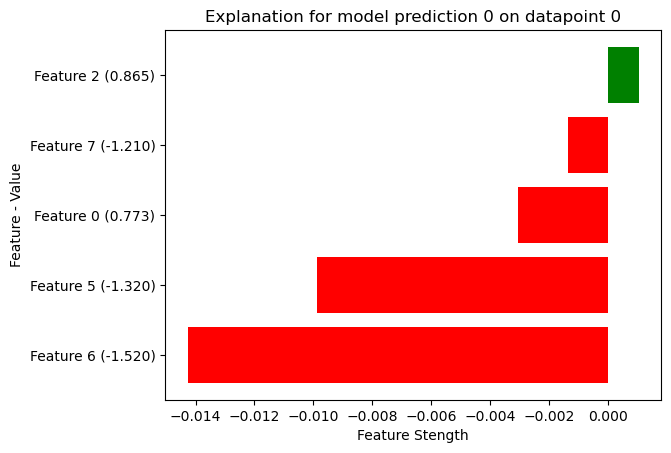


Explaining Model Prediction 1 for datapoint 2
Samples shape after removing padding: (101, 10)
Generating the sparse local model
Shortlisted features: ['Feature 4', 'Feature 6', 'Feature 7', 'Feature 8', 'Feature 9']
Found local linear model with Coeffs: [-0.00133885 -0.00158251  0.02495426 -0.00126575  0.00630601]
Explanation:
Feature 7: Value 1.374, Strength 0.024954258475394
Feature 9: Value 0.994, Strength 0.006306012559556172
Feature 8: Value -2.006, Strength -0.0012657476072962094
Feature 4: Value -1.340, Strength -0.0013388539051405815
Feature 6: Value 1.943, Strength -0.0015825124824051184


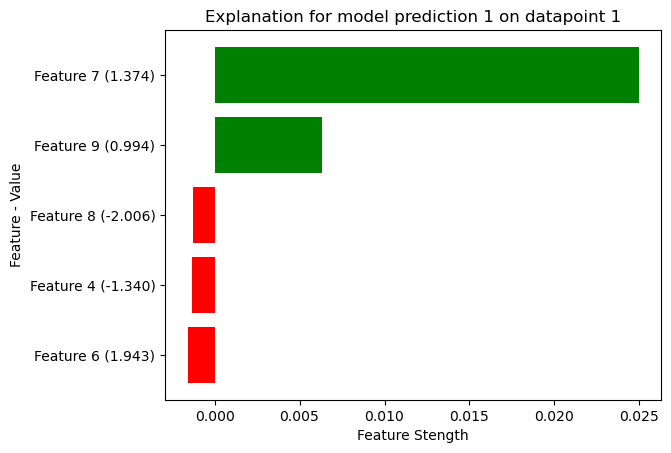


Explaining Model Prediction 1 for datapoint 3
Samples shape after removing padding: (101, 10)
Generating the sparse local model
Shortlisted features: ['Feature 3', 'Feature 4', 'Feature 6', 'Feature 8', 'Feature 9']
Found local linear model with Coeffs: [-0.018758   -0.01890958  0.01119285  0.00822003 -0.0644178 ]
Explanation:
Feature 6: Value 0.956, Strength 0.011192852028687642
Feature 8: Value 1.100, Strength 0.008220029982557372
Feature 3: Value 1.133, Strength -0.018757999520013818
Feature 4: Value 1.030, Strength -0.01890957889494304
Feature 9: Value 1.597, Strength -0.06441780083699822


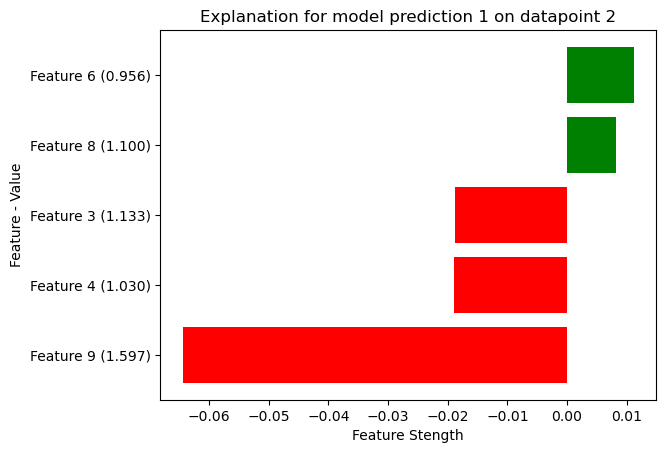


Explaining Model Prediction 1 for datapoint 4
Samples shape after removing padding: (101, 10)
Generating the sparse local model
Shortlisted features: ['Feature 2', 'Feature 4', 'Feature 6', 'Feature 7', 'Feature 8']
Found local linear model with Coeffs: [ 0.00648484  0.00111086  0.00631014  0.02429698 -0.0065661 ]
Explanation:
Feature 7: Value 0.766, Strength 0.024296984570717602
Feature 2: Value -0.528, Strength 0.006484839141362505
Feature 6: Value 1.570, Strength 0.006310137359849819
Feature 4: Value 0.742, Strength 0.001110862742440142
Feature 8: Value -1.608, Strength -0.006566103497908603


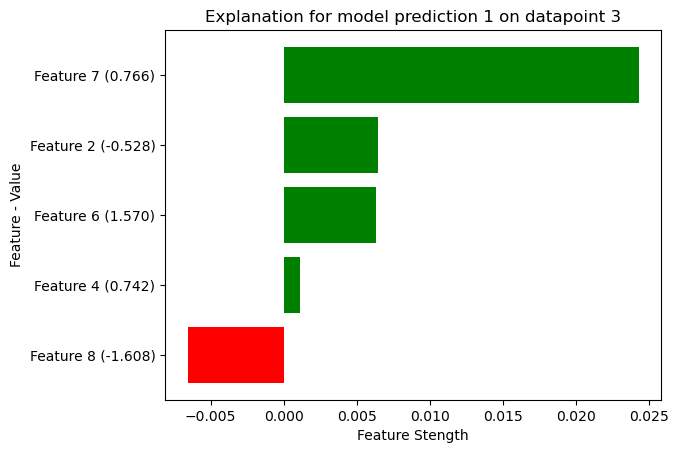


Explaining Model Prediction 0 for datapoint 5
Samples shape after removing padding: (101, 10)
Generating the sparse local model
Shortlisted features: ['Feature 0', 'Feature 2', 'Feature 6', 'Feature 8', 'Feature 9']
Found local linear model with Coeffs: [-0.00228383  0.01743311 -0.00574531 -0.02380175  0.0117499 ]
Explanation:
Feature 2: Value 1.442, Strength 0.017433109754655337
Feature 9: Value -2.907, Strength 0.011749899484792508
Feature 0: Value 1.471, Strength -0.0022838300600640745
Feature 6: Value -2.272, Strength -0.005745306227696472
Feature 8: Value -1.162, Strength -0.023801754107254495


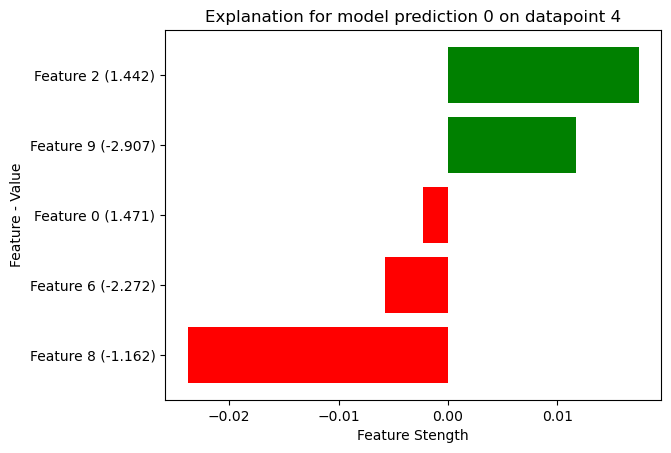

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge


def lime_on_synthetic_classification_data(hp:LimeHyperparameters,
                                          explanation_model:Any):
    n_test_data, in_features, n_classes = 5, 10, 2
    # Generate data
    X, y = make_classification(n_samples=1000, n_features=in_features, n_classes=n_classes,
                            random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Train blackbox model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Select test sample for explanation
    test_sample = X_test[np.random.randint(X_test.shape[0], size=n_test_data), :]
    # Explain the model action on the test data
    lmodel = xProbClassificationModel(model, (in_features,), (n_classes,))
    ldata = LimeData(test_sample, hp)
    # Using the default Ridge regression explanation model
    lime = Lime(hp, explanation_model)
    lime.explain(lmodel, ldata)

HP = LimeHyperparameters()
EXPLANATION_MODEL = Ridge()
lime_on_synthetic_classification_data(HP, EXPLANATION_MODEL)